# 0. Import packages

In [179]:
import os
import cv2
import json
import umap
import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from torchvision import datasets, transforms
from scipy.stats import differential_entropy, norm

# 1. Load layer activation

In [162]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def get_layer_act_path(layer):
    return f'/raid/NeuEvo/data/layer_act/vgg19_pretrained/data/{layer}/img_emb.txt'

In [161]:
layers = [
    'Sequential_0_Conv2d_7',
    'Sequential_0_Conv2d_12',
    'Sequential_0_Conv2d_16',
    'Sequential_0_Conv2d_21',
    'Sequential_0_Conv2d_25',
    'Sequential_0_Conv2d_30',
    'Sequential_0_Conv2d_34',
]

In [164]:
layer_act = {}
with tqdm(total=len(layers)) as pbar:
    for layer in layers:
        layer_act[layer] = np.loadtxt(get_layer_act_path(layer))
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [25:48<00:00, 221.22s/it]


# 2. Find similar images by cosine similarity of layer activation

In [165]:
def cos_sim(a, b):
    d = a.dot(b)
    if d == 0:
        return 0
    return d / (np.linalg.norm(a) * np.linalg.norm(b))

In [167]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

In [168]:
def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()

def show_training_imgs_2_rows(img_idxs):
    imgs = []
    subplot_titles = []
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'img: {img_idx}')
    show_np_imgs_2_rows(imgs)

In [219]:
img = 300000
layer = 'Sequential_0_Conv2d_25'

v_img = layer_act[layer][img]
num_imgs = len(layer_act[layer])
cos_sims = [0] * num_imgs
for i, v in enumerate(layer_act[layer]):
    cos_sims[i] = cos_sim(v_img, v)
cos_sims = np.array(cos_sims)

[1.         1.         0.93358367 0.92957763 0.92843361 0.92776675
 0.92625607 0.92597488 0.92566117 0.92544278 0.92506426 0.92502264
 0.9239138  0.92385501 0.92377914 0.92333038 0.92318637 0.92316399
 0.92274244 0.92271228]


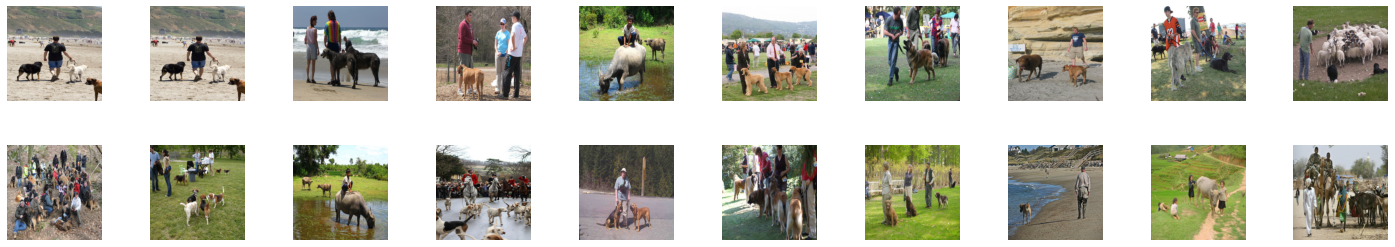

In [220]:
neighbor_imgs = np.argsort(-cos_sims)[:20]
print(cos_sims[neighbor_imgs])
show_training_imgs_2_rows(neighbor_imgs)

# 3. Find similar images by DBSCAN based on cosine similarity distance

## 3-1. Depth=0

### 3-1-1. Sample images

In [488]:
N = 120000
sampled_imgs = np.random.choice(num_imgs, N, replace=False)
print(f'Sampled {N} images ({N / num_imgs * 100:.2f}%)')

Sampled 120000 images (9.37%)


### 3-1-2. Run DBSCAN with different eps values

In [531]:
def run_dbscan(eps_vals, sampled_imgs, img_vecs):
    # Sampled image vectors
    Xs = img_vecs[sampled_imgs]
    
    # Fit DBSCAN
    dbscan = {}
    with tqdm(total=len(eps_vals)) as pbar:
        for eps in eps_vals:
            dbs = DBSCAN(eps=eps, metric='cosine', min_samples=2).fit(Xs)
            dbscan[eps] = dbs
            pbar.update(1)
            
    # Parse groups
    group = {}
    for eps in eps_vals:
        group[eps] = {}
        for i, l in enumerate(dbscan[eps].labels_):
            if l not in group[eps]:
                group[eps][l] = []
            img_idx = sampled_imgs[i]
            group[eps][l].append(img_idx)
    
    # Parse representative sample
    rep_samples = {}
    for eps in eps_vals:
        rep_samples[eps] = {}
        for l in group[eps]:
            imgs = group[eps][l]
            rep_samples[eps][l] = img_vecs[imgs]
    
    return dbscan, group, rep_samples

def get_size_of_largest_group(g):
    size = {}
    for label in g:
        s = len(g[label])
        size[label] = s
    sorted_size = sorted(size.items(), key=lambda x: x[1], reverse=True)
    return {'label': sorted_size[0][0], 'size': sorted_size[0][1]}

In [493]:
depth = 0
eps_vals = [0.05, 0.1, 0.2]
dbscan_d0, group_d0, rep_samples_d0 = run_dbscan(eps_vals, sampled_imgs, layer_act[layer])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:12<00:00, 124.29s/it]


In [532]:
print('Number of noisy samples')
for eps in eps_vals:
    print(f'eps={eps}, {len(group_d0[eps][-1])} ({len(group_d0[eps][-1]) / N * 100:.2f})%')
    
print('\nLargest group')
for eps in eps_vals:
    print(f'eps={eps}, Largest group: {get_size_of_largest_group(group_d0[eps])}')

Number of noisy samples
eps=0.05, 119464 (99.55)%
eps=0.1, 17562 (14.64)%
eps=0.2, 16 (0.01)%

Largest group
eps=0.05, Largest group: {'label': -1, 'size': 119464}
eps=0.1, Largest group: {'label': 0, 'size': 101840}
eps=0.2, Largest group: {'label': 0, 'size': 119979}


In [495]:
selected_eps = {}
selected_eps[depth] = 0.1

dbscan = {}
group = {}
rep_samples = {}

depth = 0
dbscan[depth] = dbscan_d0
group[depth] = group_d0
rep_samples_d0[depth] = rep_samples_d0

### 3-1-3. Show some example

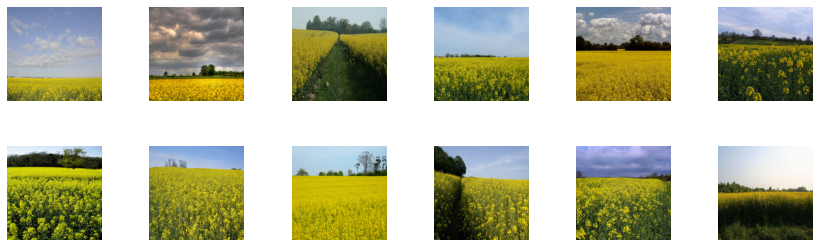

In [498]:
show_training_imgs_2_rows(group[depth][selected_eps[depth]][2])

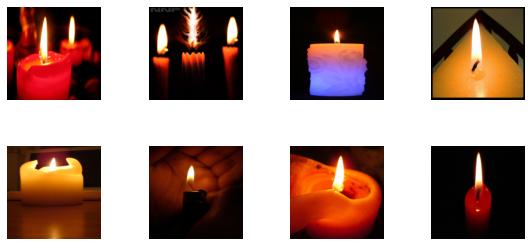

In [499]:
show_training_imgs_2_rows(group[depth][selected_eps[depth]][130])

## 3.2. Depth=1

Further running DBSCAN after depth=0. For the largest group (not noisy), use smaller eps. For the noisy group, use bigger eps.

### 3.2.1. Further cluster the largest group

In [513]:
prev_depth = 0

eps_vals = [0.005, 0.01, 0.03, 0.05]
unprocessed_imgs = group[prev_depth][selected_eps[prev_depth]][0]
dbscan_d1, group_d1, rep_samples_d1 = run_dbscan(eps_vals, unprocessed_imgs, layer_act[layer])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:51<00:00, 72.88s/it]


In [515]:
print('Number of noisy samples')
for eps in eps_vals:
    if -1 in group_d1[eps]:
        print(f'eps={eps}, {len(group_d1[eps][-1])} ({len(group_d1[eps][-1]) / N * 100:.2f})%')
    else:
        print(f'eps={eps}, No noisy samples')

Number of noisy samples
eps=0.005, 101722 (84.77)%
eps=0.01, 101718 (84.77)%
eps=0.03, 101704 (84.75)%
eps=0.05, 101310 (84.42)%


In [534]:
print('Largest group')
for eps in eps_vals:
    print(f'eps={eps}, Largest group: {get_size_of_largest_group(group_d1[eps])}')

Largest group
eps=0.005, Largest group: {'label': -1, 'size': 101722}
eps=0.01, Largest group: {'label': -1, 'size': 101718}
eps=0.03, Largest group: {'label': -1, 'size': 101704}
eps=0.05, Largest group: {'label': -1, 'size': 101310}


In [535]:
for eps in eps_vals:
    print (f'eps={eps}, num of groups = {len(group_d1[eps])}')

eps=0.005, num of groups = 60
eps=0.01, num of groups = 62
eps=0.03, num of groups = 69
eps=0.05, num of groups = 238


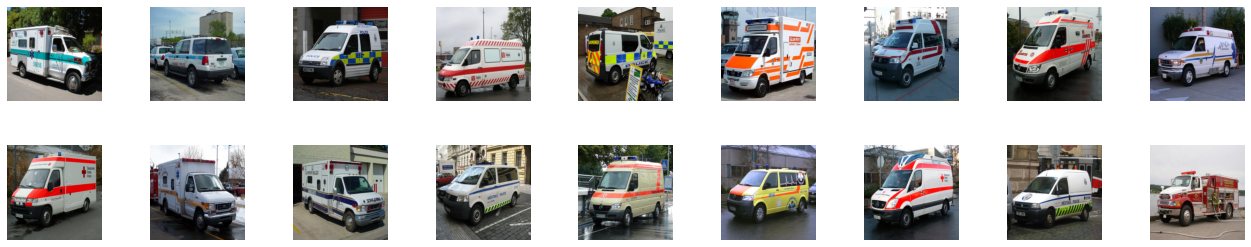

In [544]:
show_training_imgs_2_rows(group_d1[0.05][5])

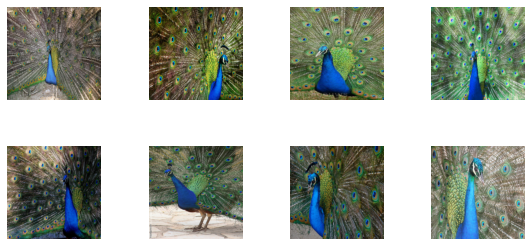

In [545]:
show_training_imgs_2_rows(group_d1[0.05][25])